In [1]:
from centersdisplaying import *
from os import listdir
from os.path import isfile, join
import re
import numpy as np
from import_images import import_images_from_path
from cellmask_model import CellMaskModel
import os
import matplotlib.pyplot as plt
import torch
import cv2
import time
import pickle

c:\Users\rz200\AppData\Local\anaconda3\envs\cellprob\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import the cell_centers2.txt file without numpy
with open("cell_centers", "rb") as fp:   # Unpickling
    cell_centers = pickle.load(fp)
cell_centers = [[(item[0], item[1]) for item in arr] for arr in cell_centers]

#import the images#
images = np.array(import_images_from_path('data/',num_imgs=3,normalisation=True))

model = CellMaskModel()
model.import_model('saved_weights/cp_model', 'saved_weights/mask_model')
#cps, masks, instance_masks = model.eval(images) #Making predictions

#Let's import the ground truth instance masks which are npy files
instance_masks_path = str('data_for_cellpose\\')
onlyfiles = [f for f in listdir(instance_masks_path) if isfile(join(instance_masks_path, f)) and f.endswith('.npy')]
onlyfiles.sort(key=lambda f: int(re.sub('\D', '', f))) #sort the files in order
gt_instance_masks = [np.load(instance_masks_path + onlyfiles[i], allow_pickle=True).item()['masks'] for i in range(len(onlyfiles))]
gt_instance_masks = gt_instance_masks[:3]

#start = time.time()
encodings_cp = get_encodings(images, model, encoder_type='cp')
encodings_mk = get_encodings(images, model, encoder_type='mask')

#I want to get the encodings from both encoders
#Then I want to average them together

encFeats_per_cell_per_mask_cp = get_encFeats_per_cell_per_mask(gt_instance_masks, encodings_cp)
#print(encFeats_per_cell_per_mask_cp[0])
encFeats_per_cell_per_mask_mk = get_encFeats_per_cell_per_mask(gt_instance_masks, encodings_mk)

#print(encFeats_per_cell_per_mask_mk.shape)
cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp)
cos_sims_per_cell_masks_encFeats_mk = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_mk)
cos_sims_per_cell_masks_encFeats_mean = np.mean([cos_sims_per_cell_masks_encFeats_cp, cos_sims_per_cell_masks_encFeats_mk], axis=0)

c:\Users\rz200\Documents\development3\cellprobabilityUNet\cellmask\centersdisplaying.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  encFeats_per_cell_per_mask = np.array(encFeats_per_cell_per_mask)


In [152]:
def get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask,max_distance=None):
    cos_sims_for_each_cell = []
    for i in range(len(encFeats_per_cell_per_mask[0])):
        #print(i)
        cell_encFeats = encFeats_per_cell_per_mask[0][i]
        cos_sims_for_cell = []
        #arr1 = cell_encFeats.flatten()
        #print(arr1.shape)
        for j in range(len(encFeats_per_cell_per_mask[1])):
            cell_encFeats2 = encFeats_per_cell_per_mask[1][j]
            #if the distance center between each cell is over 100, cos_sims_for_cell.append(0)
            if max_distance is not None:
                if abs(cell_centers[0][i][0] - cell_centers[1][j][0]) > max_distance or abs(cell_centers[0][i][1] - cell_centers[1][j][1]) > max_distance:
                    cos_sims_for_cell.append(0)
                    continue

            #the issue is that we're flattening the array and calculating the cosine similarity, but we should actually flatten the channels individually
            #print(cell_encFeats2.shape)
            cos_sims_per_channel = []
            #if the length difference between arr1 and arr2 is over 25%, cos_sim == 0
            #if abs(cell_encFeats.shape[0] - cell_encFeats2.flatten().shape[0]) > 0.1 * max(cell_encFeats.shape[0], cell_encFeats2.flatten().shape[0]):
            #    cos_sims_per_channel.append(0)
            #    continue
            for k in range(len(cell_encFeats2)):
                arr1_channel = cell_encFeats[k].flatten()
                arr2_channel = cell_encFeats2[k].flatten()
                #print(arr2.shape)
                #if the length difference between arr1 and arr2 is over 25%, cos_sim == 0
                #if abs(arr1_channel.shape[0] - arr2_channel.shape[0]) > 0.1 * max(arr1_channel.shape[0], arr2_channel.shape[0]):
                #    cos_sims_for_cell.append(0)
                #    continue

                #get the mean of each array
                #arr1_mean = np.mean(arr1)
                #arr2_mean = np.mean(arr2)
                #cos_sims_for_cell.append(abs(arr1_mean - arr2_mean)) #append the absolute value of the difference between the two means
                
            
                #pad the shorter array with the mean of the array
                #print(arr1_channel.shape, arr2_channel.shape)
                if arr1_channel.shape[0] > arr2_channel.shape[0]:
                    pad_by = arr1_channel.shape[0]-arr2_channel.shape[0]
                    arr2_channel = np.pad(arr2_channel, (0, pad_by), 'mean')
                    #arr2 = np.pad(arr2, (0, arr1.shape[0] - arr2.shape[0]), 'mean')
                    #arr1 = arr1[:arr2.shape[0]]
                elif arr1_channel.shape[0] < arr2_channel.shape[0]:
                    arr2_channel = arr2_channel[:arr1_channel.shape[0]]
                    #arr1 = np.pad(arr1, (0, arr2.shape[0] - arr1.shape[0]), 'mean')
                    #arr2 = arr2[:arr1.shape[0]]
                #print(len(arr1[0]),len(arr2[0]))
                cos_sim = np.dot(arr1_channel, arr2_channel) / (np.linalg.norm(arr1_channel) * np.linalg.norm(arr2_channel))
                cos_sims_per_channel.append(cos_sim)
            
            #print(cos_sims_per_channel)
            cos_sims_for_cell.append(np.mean(cos_sims_per_channel))

        cos_sims_for_each_cell.append(cos_sims_for_cell)

    cos_sims_for_each_cell = np.array(cos_sims_for_each_cell)

    lst = cos_sims_for_each_cell.tolist()
    return lst

In [134]:
cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp)
cos_sims_per_cell_masks_encFeats_mk = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_mk)
cos_sims_per_cell_masks_encFeats_mean = np.mean([cos_sims_per_cell_masks_encFeats_cp, cos_sims_per_cell_masks_encFeats_mk], axis=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
1

In [182]:
print(cos_sims_per_cell_masks_encFeats_mean.shape)

(267, 262)


0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195


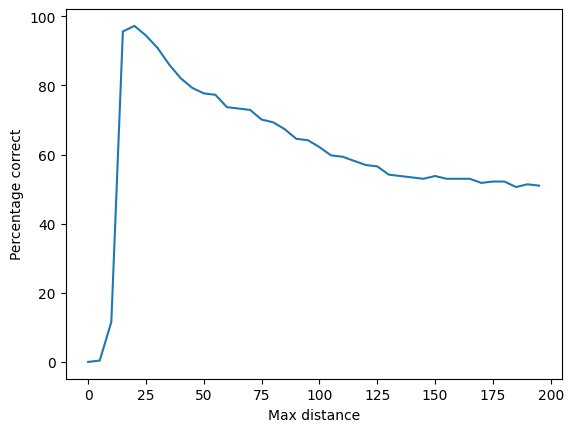

In [159]:
correct_pairs = [(32, 46), (115, 151), (26, 39), (81, 103), (233, 237), (29, 41), (136, 176), (248, 79), (197, 6), (168, 217), (13, 17), (66, 87), (217, 192), (89, 116), (244, 139), (7, 10), (185, 251), (104, 135), (24, 35), (123, 157), (62, 83), (72, 93), (181, 247), (182, 246), (82, 104), (90, 117), (119, 153), (202, 105), (99, 129), (38, 55), (151, 194), (86, 113), (198, 34), (189, 31), (143, 183), (224, 236), (25, 36), (173, 227), (79, 101), (63, 84), (161, 207), (242, 171), (73, 94), (194, 30), (246, 132), (65, 86), (120, 154), (40, 54), (174, 228), (154, 259), (49, 66), (87, 114), (27, 38), (126, 160), (232, 233), (223, 230), (36, 50), (121, 155), (207, 124), (106, 136), (150, 191), (159, 203), (144, 184), (152, 197), (205, 106), (153, 196), (227, 255), (122, 156), (93, 120), (208, 141), (88, 115), (226, 241), (155, 199), (257, 45), (51, 68), (200, 112), (214, 193), (145, 185), (158, 204), (225, 239), (70, 91), (240, 175), (103, 133), (75, 96), (97, 126), (135, 174), (238, 260), (33, 44), (85, 109), (71, 92), (111, 146), (228, 249), (23, 33), (52, 69), (60, 82), (255, 212), (67, 88), (250, 51), (175, 231), (124, 158), (95, 122), (252, 261), (258, 256), (184, 252), (142, 182), (53, 70), (193, 19), (47, 63), (253, 40), (91, 118), (192, 21), (100, 130), (3, 5), (56, 75), (94, 123), (222, 226), (43, 59), (254, 206), (209, 128), (105, 138), (146, 188), (78, 99), (160, 205), (19, 22), (212, 163), (125, 159), (162, 208), (199, 53), (230, 242), (133, 172), (156, 201), (16, 23), (113, 148), (74, 95), (165, 213), (54, 71), (92, 119), (50, 67), (149, 189), (229, 243), (157, 202), (35, 48), (44, 60), (69, 89), (84, 108), (166, 214), (107, 137), (116, 149), (243, 168), (210, 165), (134, 173), (188, 0), (30, 42), (171, 222), (45, 61), (15, 20), (68, 90), (117, 150), (18, 25), (102, 131), (41, 57), (14, 18), (55, 74), (203, 107), (196, 4), (98, 127), (1, 2), (221, 216), (191, 26), (10, 14), (260, 177), (179, 244), (216, 192), (83, 102), (231, 238), (112, 147), (204, 111), (180, 245), (131, 169), (42, 58), (176, 232), (61, 80), (235, 235), (2, 3), (241, 166), (11, 15), (34, 47), (147, 186), (48, 64), (101, 134), (57, 76), (127, 162), (164, 211), (247, 11), (37, 52), (249, 72), (130, 164), (211, 161), (12, 16), (148, 187), (132, 170), (21, 28), (58, 77), (96, 125), (172, 224), (178, 240), (8, 12), (186, 253), (17, 24), (22, 29), (251, 81), (137, 178), (219, 195), (234, 248), (118, 152), (237, 219), (129, 167), (109, 143), (167, 215), (206, 121), (169, 221), (170, 220), (59, 78), (213, 200), (0, 1), (236, 229), (9, 13), (261, 258), (187, 254), (39, 56), (31, 43), (46, 62), (239, 209), (195, 32), (163, 217), (141, 180), (183, 250), (177, 234), (4, 7), (64, 85), (20, 27), (5, 8), (259, 190), (245, 145), (77, 97), (28, 37), (256, 218), (220, 198), (139, 179), (163, 210), (6, 9)]
max_distances = [i for i in range(0,200,5)]
percentage_correct = []
for max_dist in max_distances:
    print(max_dist)
    cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp,max_distance=max_dist)
    predicted_pairs = get_pairs(cos_sims_per_cell_masks_encFeats_cp)
    #get the percentage of correct pairs in predicted_pairs
    count = 0
    for i in range(len(predicted_pairs)):
        if predicted_pairs[i] in correct_pairs:
            count += 1
    percentage_correct.append(count/len(correct_pairs)*100)
plt.plot(max_distances, percentage_correct)
plt.xlabel('Max distance')
plt.ylabel('Percentage correct')
plt.show()

In [194]:
##CELL CENTERS
#match the cells with the ones they have the lowest distance from in the second image and get the percentage of correct matches

#get the distance between every cell in the first image and every cell in the second image
distances_per_cells = []
for i in range(len(cell_centers[0])):
    distances = []
    for j in range(len(cell_centers[1])):
        #get the distance between the two centers which are tuple coordinates
        distance = np.linalg.norm(np.array(cell_centers[0][i])-np.array(cell_centers[1][j]))
        distances.append(distance)
    distances_per_cells.append(distances)
distances_per_cells = np.array(distances_per_cells)

pairs = []
length = min(len(distances_per_cells),len(distances_per_cells[0]))
for i in range(length):
    distances_per_cells = np.array(distances_per_cells)
    max_index = np.argmin(distances_per_cells)
    #print(max_index)
    row, col = np.unravel_index(max_index, distances_per_cells.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    distances_per_cells[:,col] = 1090
    distances_per_cells[row,:] = 1090
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


90.43824701195219


In [196]:
#ONLY CP ENCODINGS
cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp)

similarity_index = cos_sims_per_cell_masks_encFeats_cp

pairs = []
length = min(len(similarity_index),len(similarity_index[0]))
for i in range(length):
    similarity_index = np.array(similarity_index)
    max_index = np.argmax(similarity_index)
    #print(max_index)
    row, col = np.unravel_index(max_index, similarity_index.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    similarity_index[:,col] = 0
    similarity_index[row,:] = 0
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


30.677290836653388


In [200]:
#ONLY CP ENCODINGS, 20PX radius
cos_sims_per_cell_masks_encFeats_cp = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp, max_distance=20)

similarity_index = cos_sims_per_cell_masks_encFeats_cp

pairs = []
length = min(len(similarity_index),len(similarity_index[0]))
for i in range(length):
    similarity_index = np.array(similarity_index)
    max_index = np.argmax(similarity_index)
    #print(max_index)
    row, col = np.unravel_index(max_index, similarity_index.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    similarity_index[:,col] = 0
    similarity_index[row,:] = 0
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


97.21115537848605


In [197]:
#ONLY MASK ENCODINGS
cos_sims_per_cell_masks_encFeats_mk = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_mk)

similarity_index = cos_sims_per_cell_masks_encFeats_mk

pairs = []
length = min(len(similarity_index),len(similarity_index[0]))
for i in range(length):
    similarity_index = np.array(similarity_index)
    max_index = np.argmax(similarity_index)
    #print(max_index)
    row, col = np.unravel_index(max_index, similarity_index.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    similarity_index[:,col] = 0
    similarity_index[row,:] = 0
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


20.318725099601593


In [201]:
#ONLY MASK ENCODINGS, 20PX radius
cos_sims_per_cell_masks_encFeats_mk = get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_mk, max_distance=20)

similarity_index = cos_sims_per_cell_masks_encFeats_mk

pairs = []
length = min(len(similarity_index),len(similarity_index[0]))
for i in range(length):
    similarity_index = np.array(similarity_index)
    max_index = np.argmax(similarity_index)
    #print(max_index)
    row, col = np.unravel_index(max_index, similarity_index.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    similarity_index[:,col] = 0
    similarity_index[row,:] = 0
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


95.2191235059761


In [199]:
#MASK AND CP encodings meaned
cos_sims_per_cell_masks_encFeats_mean = np.mean([cos_sims_per_cell_masks_encFeats_cp, cos_sims_per_cell_masks_encFeats_mk], axis=0)

similarity_index = cos_sims_per_cell_masks_encFeats_mean

pairs = []
length = min(len(similarity_index),len(similarity_index[0]))
for i in range(length):
    similarity_index = np.array(similarity_index)
    max_index = np.argmax(similarity_index)
    #print(max_index)
    row, col = np.unravel_index(max_index, similarity_index.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    similarity_index[:,col] = 0
    similarity_index[row,:] = 0
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


28.68525896414343


In [202]:
#MASK AND CP encodings meaned, 20PX radius
cos_sims_per_cell_masks_encFeats_mean = np.mean([get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_cp, max_distance=20), get_cos_sims_per_cell_per_mask(encFeats_per_cell_per_mask_mk, max_distance=20)], axis=0)

similarity_index = cos_sims_per_cell_masks_encFeats_mean

pairs = []
length = min(len(similarity_index),len(similarity_index[0]))
for i in range(length):
    similarity_index = np.array(similarity_index)
    max_index = np.argmax(similarity_index)
    #print(max_index)
    row, col = np.unravel_index(max_index, similarity_index.shape)
    if row not in [pair[0] for pair in pairs] and col not in [pair[1] for pair in pairs]: #to not get duplicate pairs
        pairs.append((row,col))
        #print((row,col))
    similarity_index[:,col] = 0
    similarity_index[row,:] = 0
count = 0
for i in range(len(pairs)):
    if pairs[i] in correct_pairs:
        count += 1
print(count/len(correct_pairs)*100)


98.00796812749005


In [212]:
#now we'll want to get the cell's one channel information (just the cell marker) and get the cosine similarity with that and get its pairings
#we will also want to do the same method but with the radius fixed at 20px

#TODO
#mask out all the cells just on the image
#flatten the arrays out
#get the cosine similarity between the flattened arrasy
#put it through the grid array and get the percentage of correct
#do this again for the 20px radisu and get the percentage of correct

#take the images and gt_masks and use it to mask out each cell and flatten the arrays
masked_out_cells_1 = []
for i in range(1,max(np.unique(gt_instance_masks[0]))+1):
    print(i)
    cell = []
    for j in range(len(images[0])):
        for k in range(len(images[0])):
            if gt_instance_masks[0][j][k] == i:
                cell.append(images[0][j][k])
    masked_out_cells_1.append(cell)

print(len(masked_out_cells_1))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


KeyboardInterrupt: 

In [137]:
#correct_pairs = [(47, 63), (98, 127), (60, 82), (159, 203), (90, 117), (112, 147), (134, 173), (69, 89), (164, 211), (41, 57),  (158, 204), (103, 133), (100, 130), (121, 155), (51, 68), (257, 45), (165, 213), (32, 46), (220, 198), (120, 154),  (107, 137), (118, 152), (89, 116), (156, 201), (85, 109), (207, 124), (124, 158), (84, 108), (149, 189), (193, 19),  (210, 165), (246, 132), (23, 33), (129, 167), (61, 80), (88, 115), (14, 18), (39, 56), (57, 76), (81, 103), (174, 228),  (261, 258), (179, 244), (216, 192), (222, 226), (15, 20), (75, 96), (242, 171), (176, 232), (105, 138), (223, 230),  (18, 25), (244, 139), (236, 229), (195, 32), (245, 145), (209, 128), (213, 200), (199, 53), (253, 40), (206, 121),  (191, 26), (200, 112), (198, 34)]
found = 0
#check if the pairs are in the correct pairs
for pair in pairs_1:
    if pair in correct_pairs:
        found += 1

print(found, len(correct_pairs))

230 241


(1280, 1280)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
(500, 612) (493, 624)


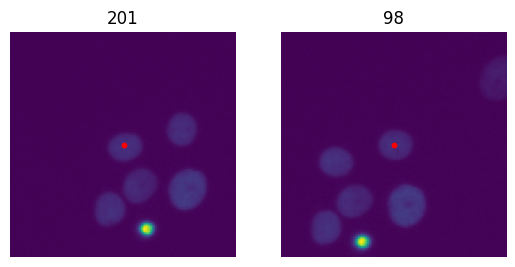

32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
(673, 192) (678, 199)


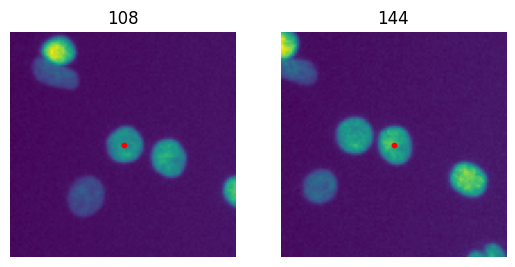

90
91
92
93
94
95
96
97
98
99
100
101
102
(922, 602) (923, 590)


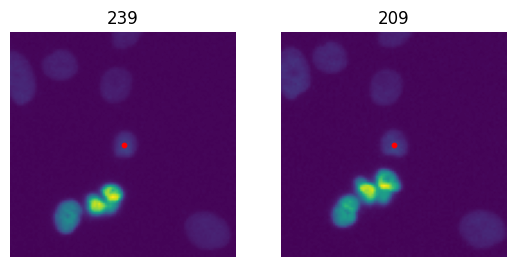

103
104
105
106
107
(869, 1109) (862, 1118)


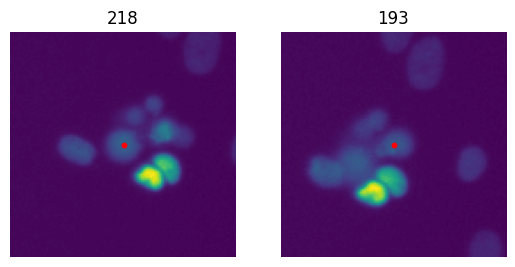

108
(363, 173) (363, 162)


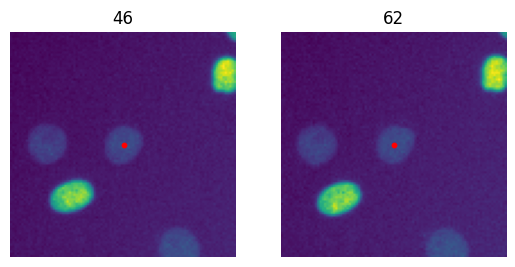

109
110
111
112
(895, 599) (897, 586)


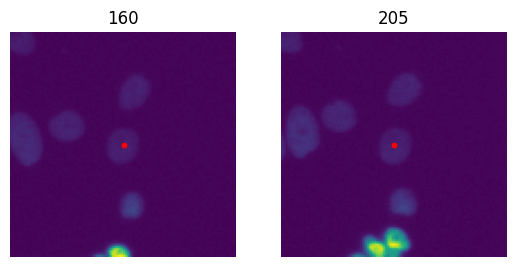

113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
(812, 627) (812, 615)


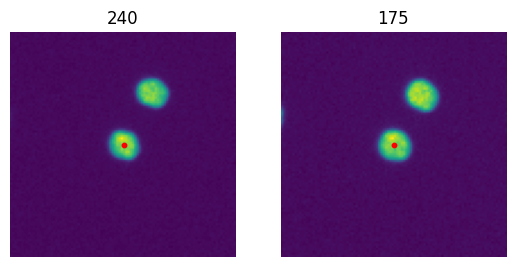

158
159
160
161
162
163
164
165
166
167
(789, 640) (790, 627)


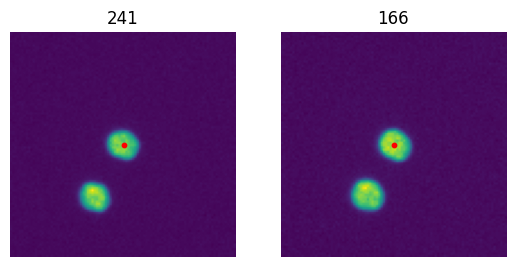

168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
(169, 1006) (165, 993)


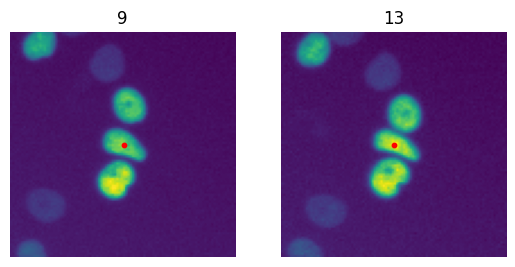

202
203
204
205
206
207
208
209
210
211
212
(184, 1002) (179, 990)


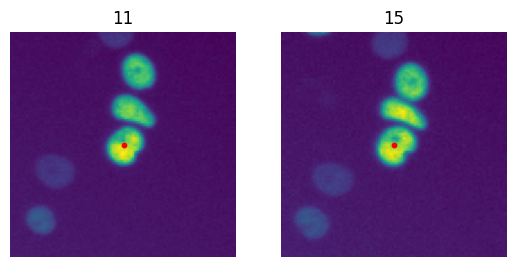

213
214
215
(362, 139) (363, 127)


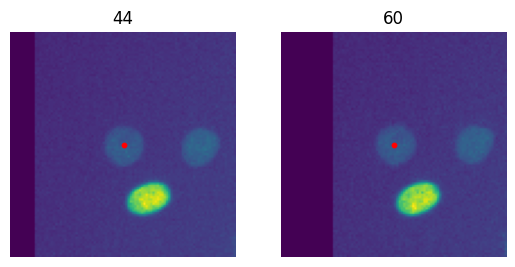

216
(838, 101) (824, 102)


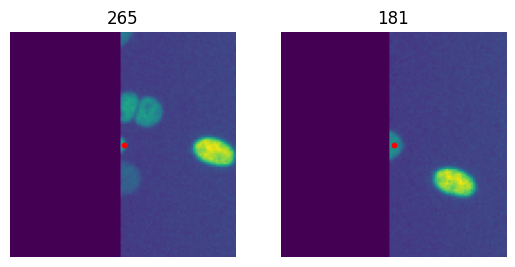

217
218
219
220
221
(332, 218) (331, 207)


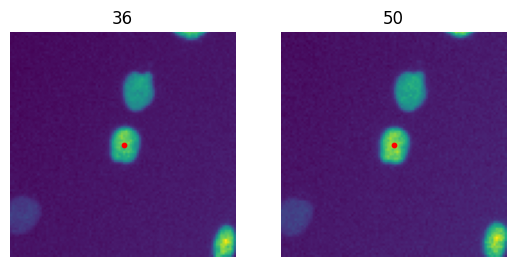

222
223
224
225
226
227
228
229
230
231
232
233
234
235
(308, 224) (307, 214)


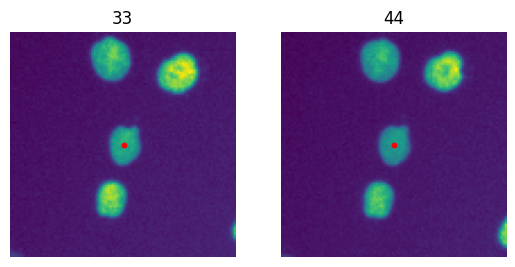

236
237
238
239
240
241
242
243


In [138]:
size_of_crops = 50
images_padded = [np.pad(image, ((100,100)), 'constant', constant_values=(0,0)) for image in images]
print(images_padded[0].shape)
pair_crops = []
for i in range(len(pairs_1)):
    
    print(i)
    pair = pairs_1[i]
    first_cell_index = pair[0]
    second_cell_index = pair[1]

    if (first_cell_index, second_cell_index) not in correct_pairs:
        first_cell_center = (round(cell_centers[0][first_cell_index][0]),round(cell_centers[0][first_cell_index][1]))
        second_cell_center = (round(cell_centers[1][second_cell_index][0]),round(cell_centers[1][second_cell_index][1]))

        #correct the centers to account for the padding
        first_cell_center = (first_cell_center[0]+100, first_cell_center[1]+100)
        second_cell_center = (second_cell_center[0]+100, second_cell_center[1]+100)

        print(first_cell_center, second_cell_center)

        crop = images_padded[0][first_cell_center[0]-size_of_crops:first_cell_center[0]+size_of_crops, first_cell_center[1]-size_of_crops:first_cell_center[1]+size_of_crops]
        crop2 = images_padded[1][second_cell_center[0]-size_of_crops:second_cell_center[0]+size_of_crops, second_cell_center[1]-size_of_crops:second_cell_center[1]+size_of_crops]
        pair_crops.append((crop, crop2))

        mmm = 3
        if mmm == 3:
            plt.subplot(1,2,1)
            plt.title(first_cell_index)
            plt.axis('off')
            plt.scatter(size_of_crops, size_of_crops, c='r', s=10)
            plt.imshow(crop)

            plt.subplot(1,2,2)
            plt.title(second_cell_index)
            plt.axis('off')
            plt.scatter(size_of_crops, size_of_crops, c='r', s=10)
            plt.imshow(crop2)
            
            plt.show()

In [37]:
print(images[0])

[[0.00085439 0.00253031 0.00285893 ... 0.00560284 0.00409122 0.00570142]
 [0.00213598 0.00225099 0.00331898 ... 0.0050442  0.00486346 0.00497848]
 [0.00230029 0.00285893 0.00287536 ... 0.00566856 0.0054221  0.00621077]
 ...
 [0.00957905 0.00964477 0.00862607 ... 0.01700568 0.01335809 0.01621702]
 [0.00862607 0.01007197 0.00984194 ... 0.01659492 0.01616772 0.01564194]
 [0.01056488 0.00844534 0.01035129 ... 0.01679209 0.01786008 0.01575696]]


In [66]:
import sys

#from scipy.misc import imread
from scipy.linalg import norm
from scipy import sum, average
from PIL import Image
from PIL import ImageChops
import math, operator


def compare_images(img1, img2):
    # normalize to compensate for exposure difference, this may be unnecessary
    # consider disabling it
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = sum(abs(diff))  # Manhattan norm
    z_norm = norm(diff.ravel(), 0)  # Zero norm
    return (m_norm, z_norm)

def calcdiff(im1, im2):
    dif = ImageChops.difference(im1, im2)
    return np.mean(np.array(dif))

In [86]:

mse = np.mean(((pair_crops[0][0] - pair_crops[0][1])**2).mean(axis=0))

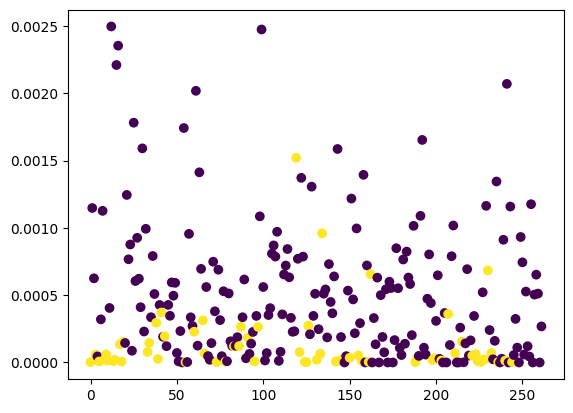

In [87]:
#calcualte mse for every pair of crops
mse_per_pair = []
for i in range(len(pair_crops)):
    mse_per_pair.append(np.mean(((pair_crops[i][0] - pair_crops[i][1])**2).mean(axis=0)))

#plot the mse for every pair of crops with the colors according to if their correct or not
plt.scatter(range(len(mse_per_pair)), mse_per_pair, c=[1 if pair in correct_pairs else 0 for pair in pairs_1])
plt.show()

C:\Users\rz200\AppData\Local\Temp\ipykernel_33856\4207610041.py:12: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
  m_norm = sum(abs(diff))  # Manhattan norm


Text(0, 0.5, 'Zero norm')

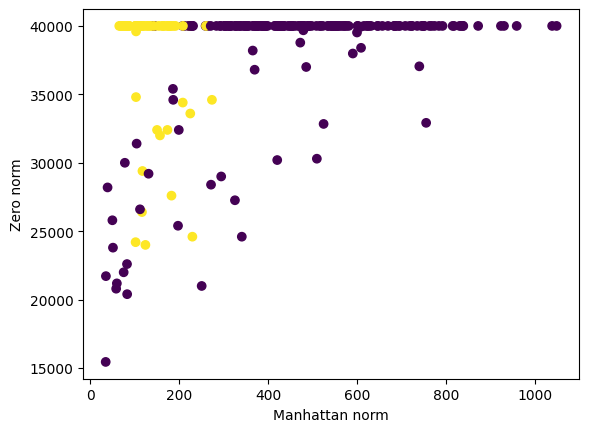

In [62]:
differences = []
for pair_crop in pair_crops:
    differences.append(compare_images(pair_crop[0], pair_crop[1]))

#get the indexes from pairs_1, if pair is in correct_pairs label the scattered point green, otherwise blue
indexes = []
for pair in pairs_1:
    if pair in correct_pairs:
        indexes.append(1)
    else:
        indexes.append(0)

plt.scatter([x[0] for x in differences], [x[1] for x in differences], c=indexes)

#plt.scatter([x[0] for x in differences], [x[1] for x in differences])
plt.xlabel('Manhattan norm')
plt.ylabel('Zero norm')

[(47, 63), (82, 221), (64, 164), (98, 127), (143, 177)]


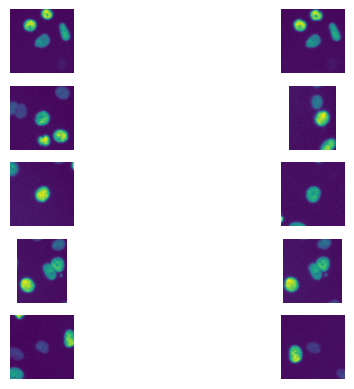

[(60, 82), (264, 79), (137, 210), (159, 203), (90, 117)]


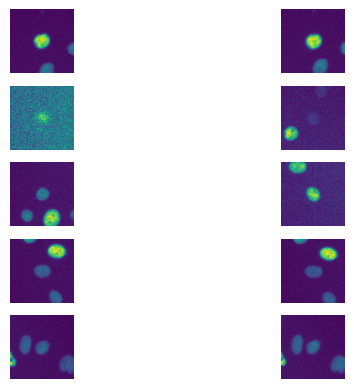

[(112, 147), (132, 172), (122, 191), (134, 173), (69, 89)]


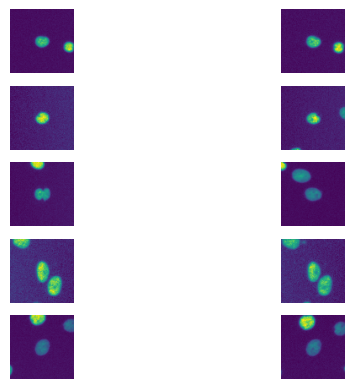

[(152, 182), (150, 251), (164, 211), (41, 57), (158, 204)]


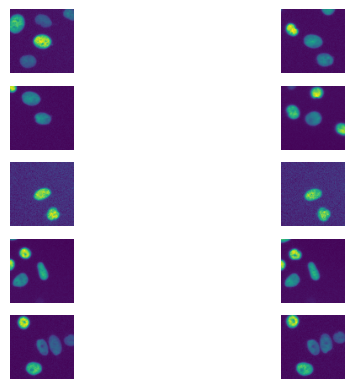

[(180, 69), (125, 157), (113, 217), (182, 129), (99, 48)]


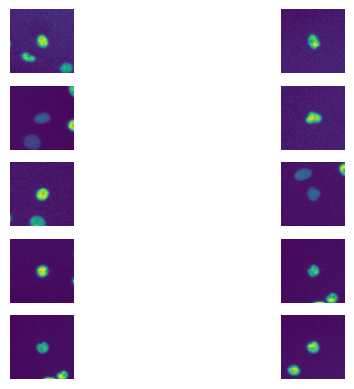

[(123, 98), (111, 150), (171, 94), (230, 185), (145, 190)]


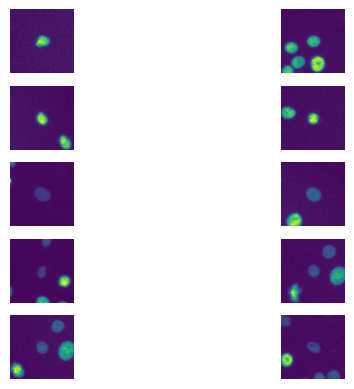

[(135, 149), (133, 247), (131, 151), (103, 133), (100, 130)]


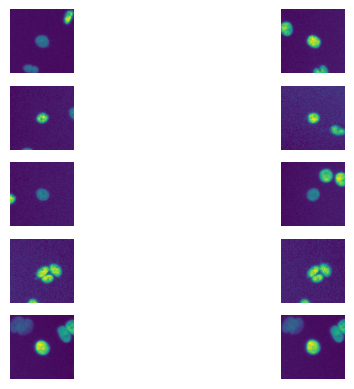

[(72, 102), (62, 240), (48, 234), (121, 155), (51, 68)]


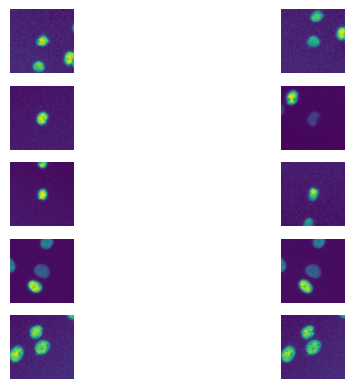

[(177, 64), (257, 45), (56, 24), (165, 213), (233, 78)]


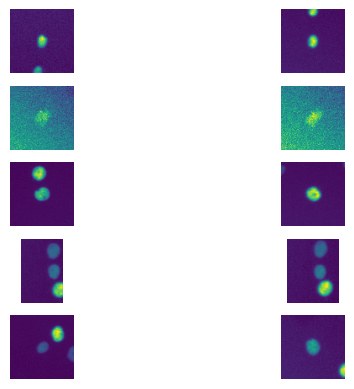

[(168, 207), (28, 90), (117, 146), (29, 77), (45, 169)]


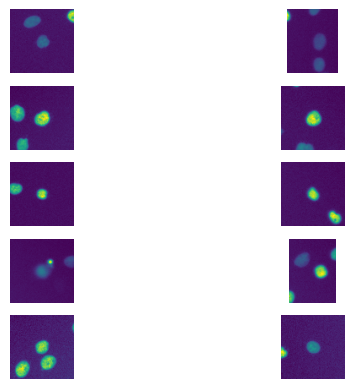

[(154, 245), (63, 183), (53, 85), (54, 71), (110, 174)]


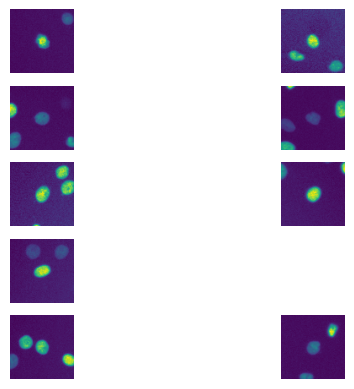

[(32, 46), (250, 54), (260, 178), (38, 50), (186, 104)]


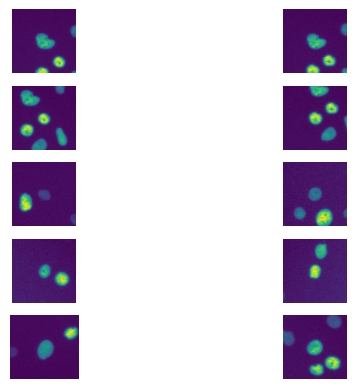

[(220, 198), (109, 83), (50, 248), (130, 227), (161, 148)]


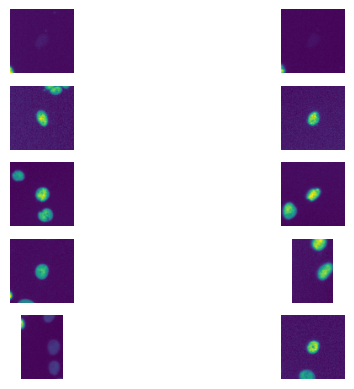

[(120, 154), (107, 137), (52, 220), (181, 196), (248, 72)]


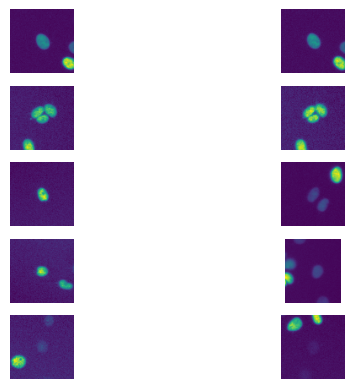

[(127, 188), (259, 170), (67, 99), (118, 152), (43, 28)]


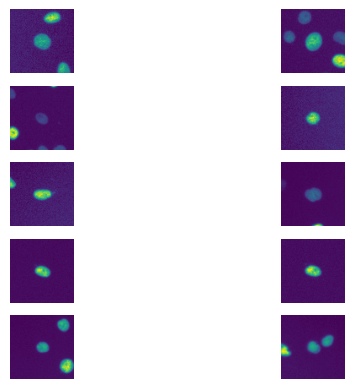

[(83, 120), (148, 186), (239, 252), (89, 116), (46, 92)]


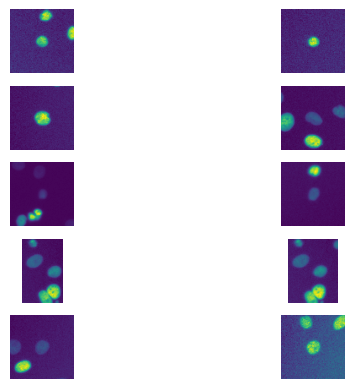

[(162, 197), (126, 51), (187, 93), (156, 201), (144, 126)]


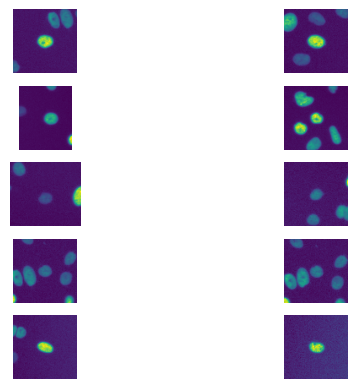

[(166, 42), (85, 109), (207, 124), (35, 134), (251, 235)]


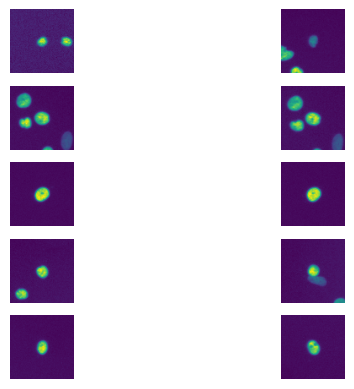

[(70, 237), (124, 158), (231, 254), (217, 216), (93, 215)]


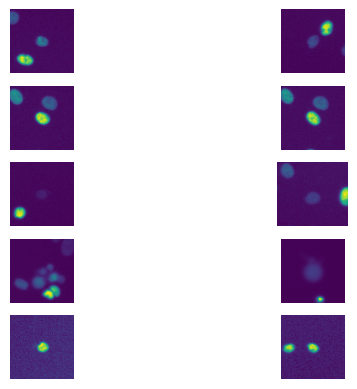

[(84, 108), (155, 205), (149, 189), (203, 14), (142, 222)]


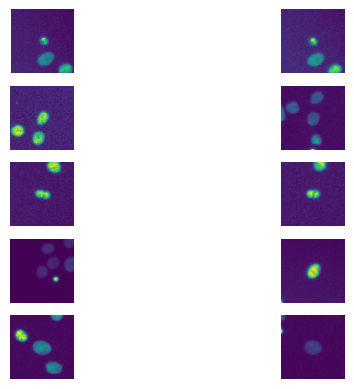

[(185, 144), (44, 62), (167, 214), (160, 91), (77, 47)]


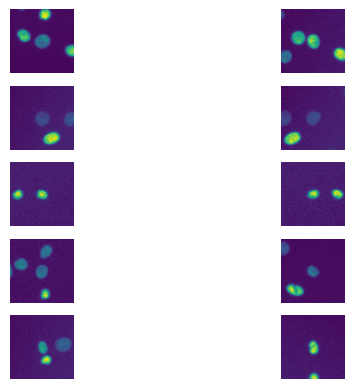

[(76, 153), (79, 202), (163, 246), (115, 135), (95, 122)]


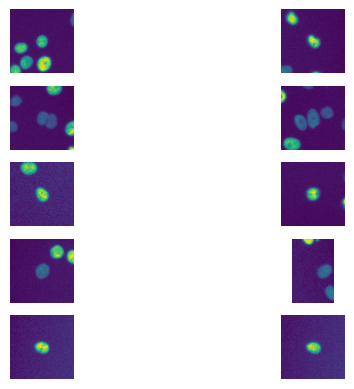

[(59, 187), (102, 199), (219, 208), (96, 105), (157, 101)]


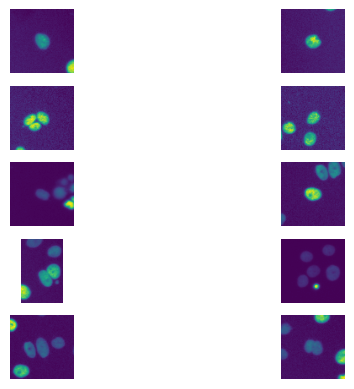

[(178, 242), (33, 55), (55, 70), (116, 84), (193, 19)]


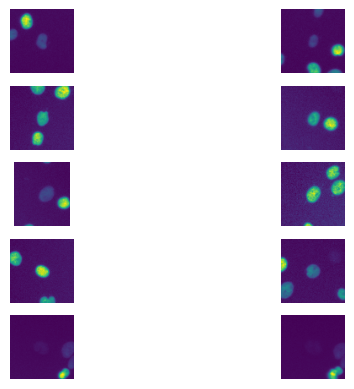

[(73, 21), (210, 165), (17, 249), (86, 81), (246, 132)]


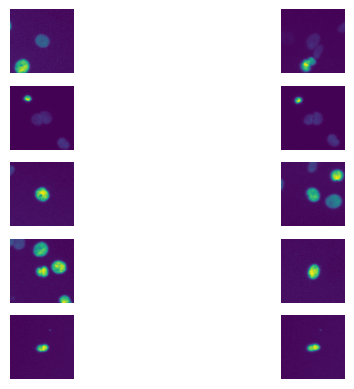

[(23, 33), (129, 167), (42, 75), (202, 142), (170, 224)]


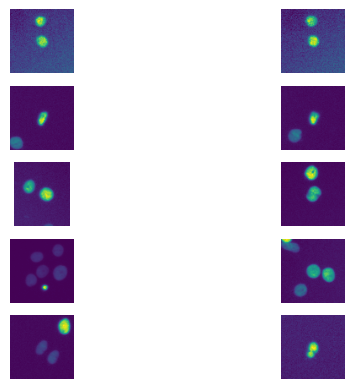

[(80, 131), (61, 80), (40, 166), (88, 115), (14, 18)]


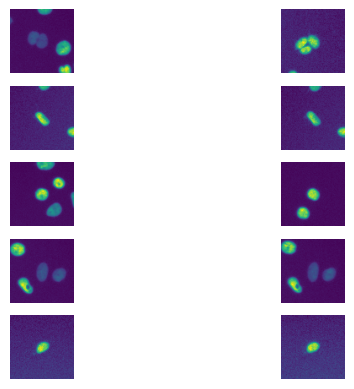

[(68, 41), (119, 113), (184, 223), (228, 255), (94, 195)]


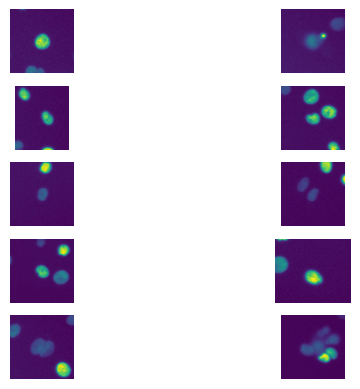

[(147, 88), (25, 179), (39, 56), (8, 100), (57, 76)]


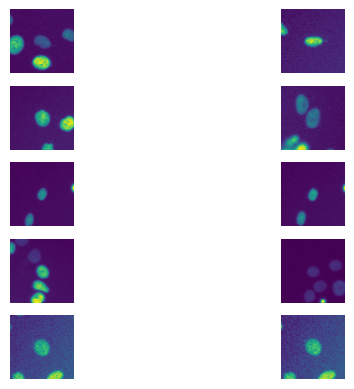

[(136, 175), (81, 103), (258, 256), (49, 231), (201, 160)]


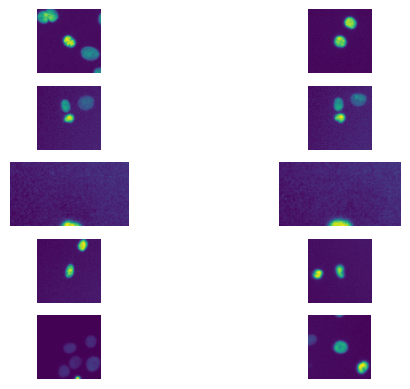

[(174, 228), (108, 106), (10, 58), (65, 95), (218, 143)]


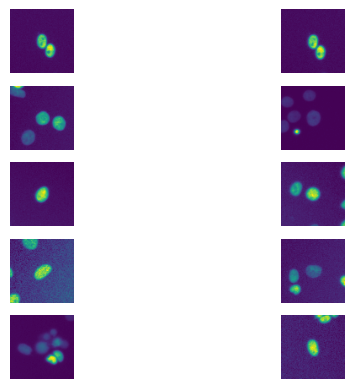

[(261, 258), (92, 176), (179, 244), (153, 35), (247, 11)]


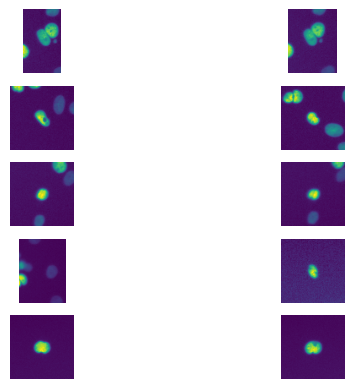

[(30, 209), (216, 192), (222, 226), (2, 3), (58, 6)]


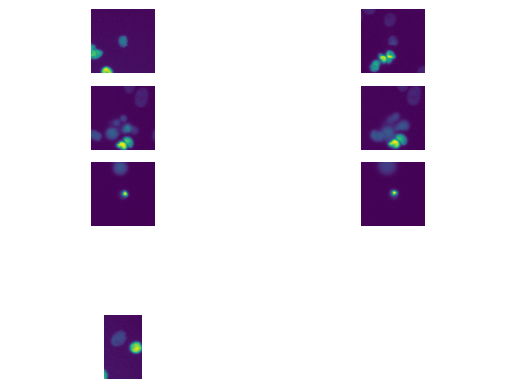

[(13, 38), (22, 184), (4, 7), (139, 52), (101, 30)]


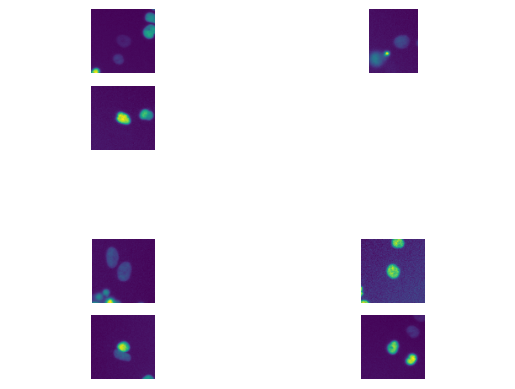

[(172, 193), (34, 59), (1, 2), (21, 156), (205, 114)]


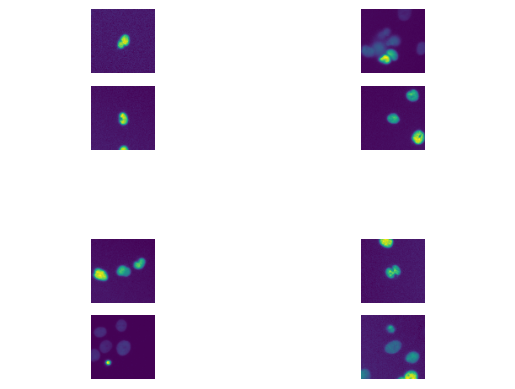

[(16, 23), (256, 206), (36, 107), (151, 118), (249, 238)]


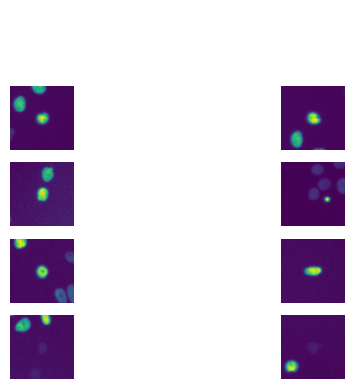

[(141, 253), (183, 136), (146, 162), (37, 29), (240, 241)]


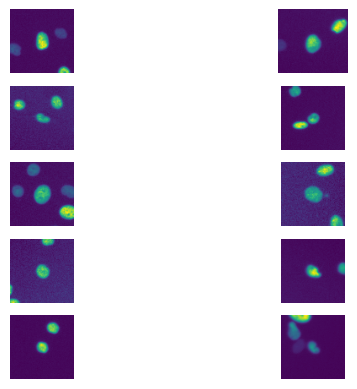

[(91, 194), (31, 16), (243, 243), (15, 20), (75, 96)]


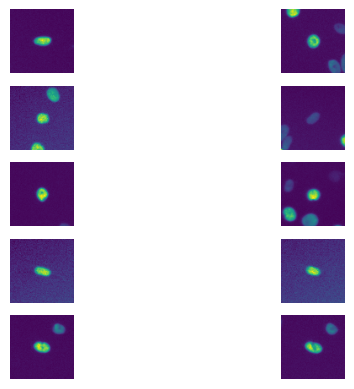

[(66, 27), (241, 168), (24, 250), (221, 180), (26, 22)]


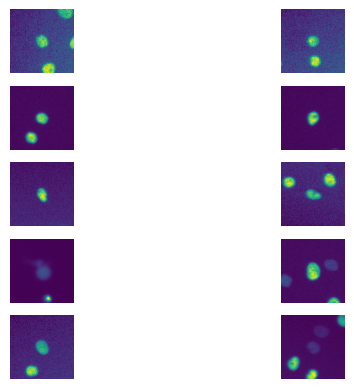

[(197, 61), (78, 123), (87, 37), (242, 171), (176, 232)]


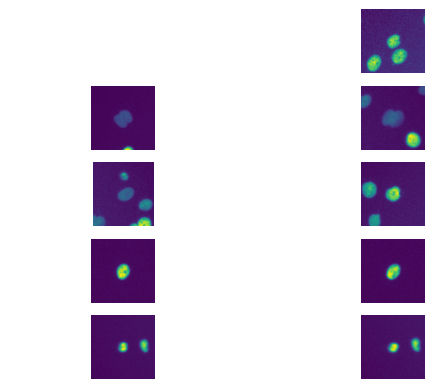

[(97, 259), (192, 159), (71, 87), (105, 138), (114, 181)]


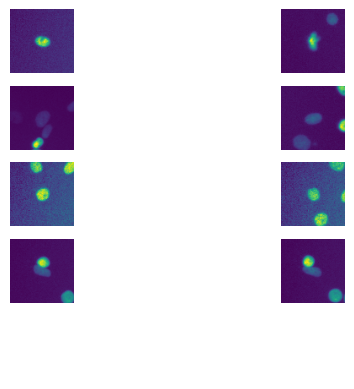

[(204, 161), (7, 10), (223, 230), (235, 67), (106, 119)]


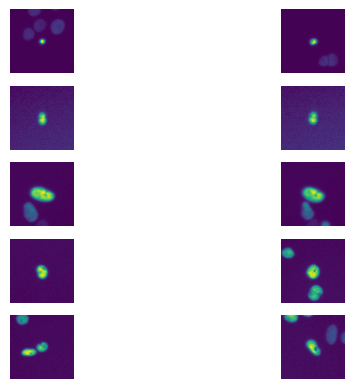

[(169, 125), (18, 25), (3, 5), (0, 1), (74, 86)]


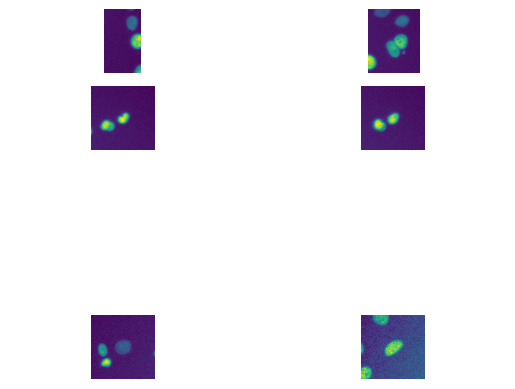

[(244, 139), (6, 12), (9, 36), (225, 74), (175, 66)]


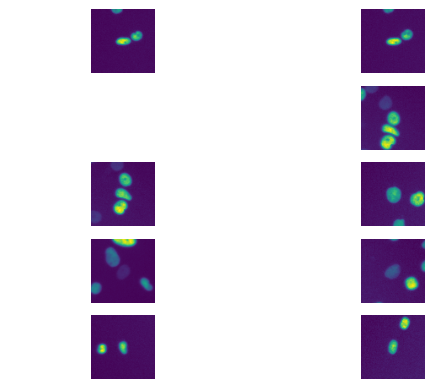

[(11, 13), (236, 229), (232, 212), (195, 32), (245, 145)]


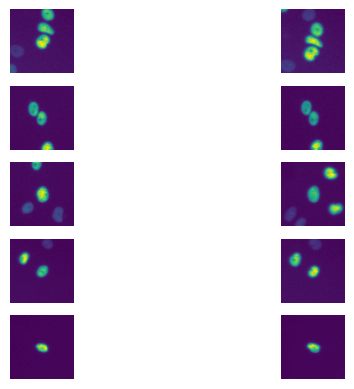

[(209, 128), (213, 200), (104, 140), (199, 53), (224, 239)]


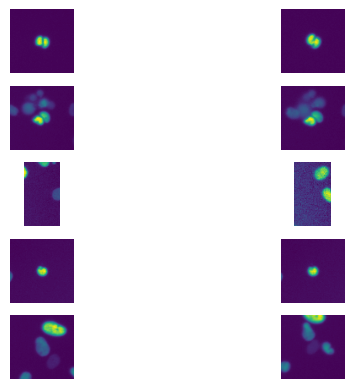

[(253, 40), (12, 43), (206, 121), (234, 261), (19, 97)]


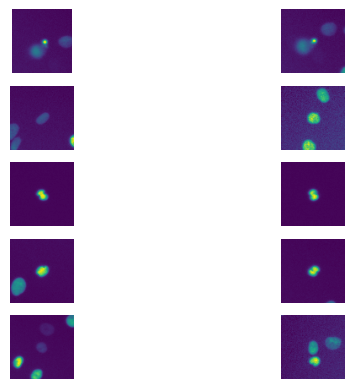

[(208, 111), (191, 26), (5, 8), (20, 17), (263, 219)]


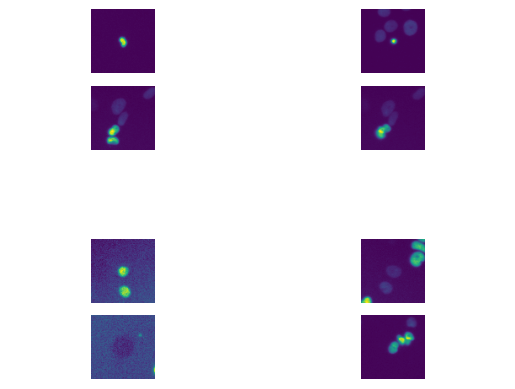

[(200, 112), (173, 15), (138, 9), (262, 4), (198, 34)]


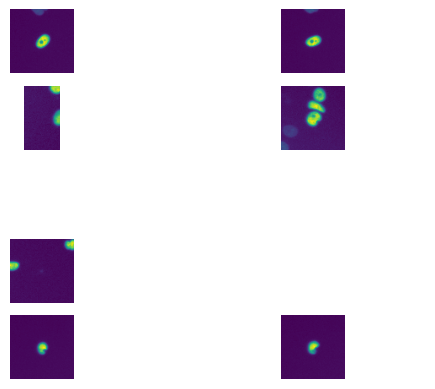

[(27, 39), (252, 31), (214, 225), (188, 0), (226, 236)]


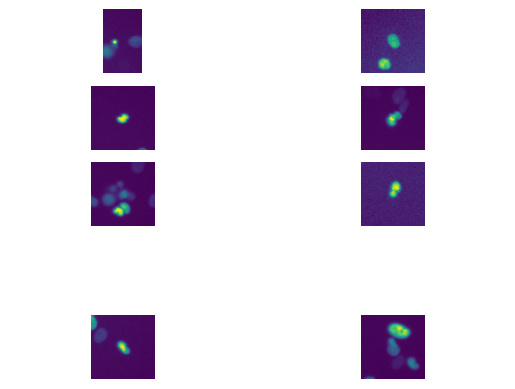

[(237, 233), (229, 218), (194, 163), (227, 110), (140, 44)]


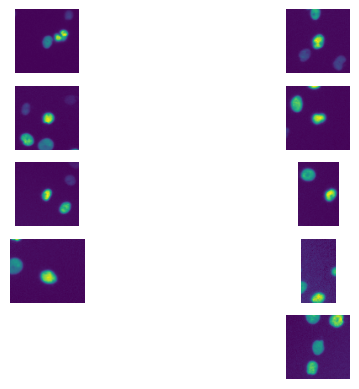

[(212, 141), (266, 60), (215, 260), (265, 65), (255, 73)]


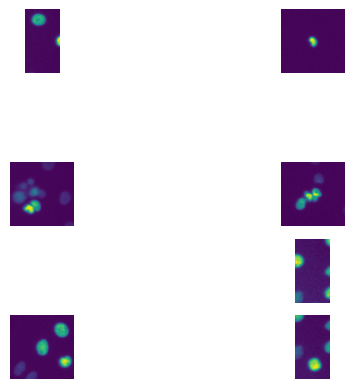

In [15]:
for i in range(0,len(pairs_1)-5,5):
    print(pairs_1[i:i+5])
    display_matches(pairs_1[i:i+5], cell_centers, images, size_of_crop=75)

In [98]:
print(np.unique(cos_sims_per_cell_masks_encFeats_cp))

[-0.46875 -0.4375  -0.40625 -0.375   -0.34375 -0.3125  -0.28125 -0.25
 -0.21875 -0.1875  -0.15625 -0.125   -0.09375 -0.0625  -0.03125  0.
  0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875  0.25
  0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875  0.5    ]


In [78]:
print(len(encFeats_per_cell_per_mask_mk[0]))
print(cell_centers[0][0])

267
(4.113475177304965, 955.4113475177305)


(3, 1280, 1280)


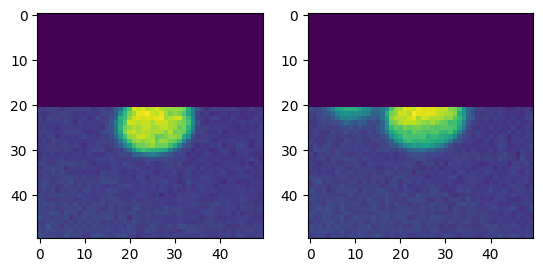

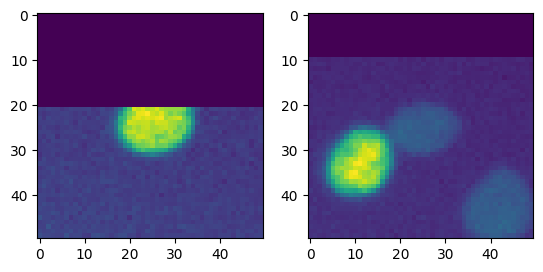

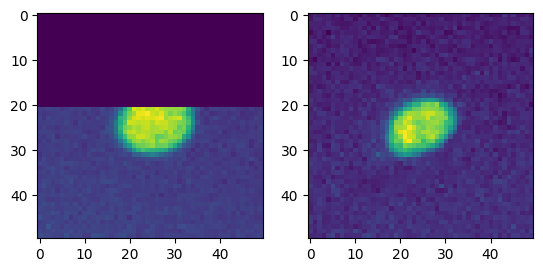

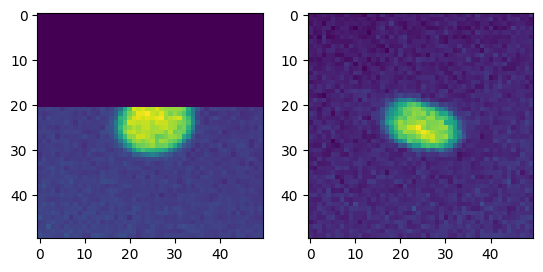

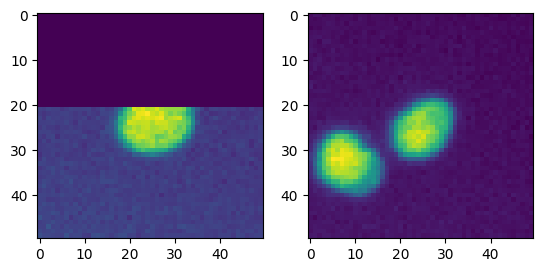

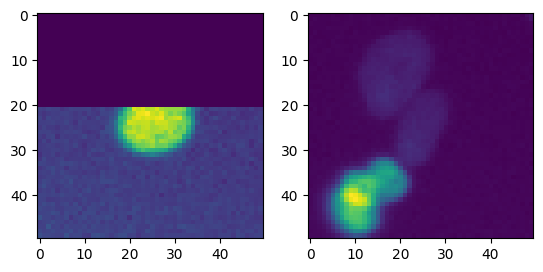

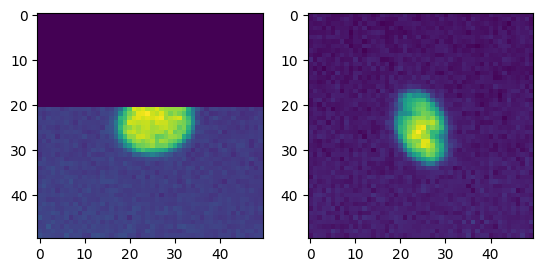

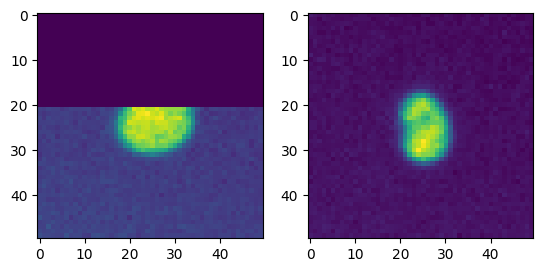

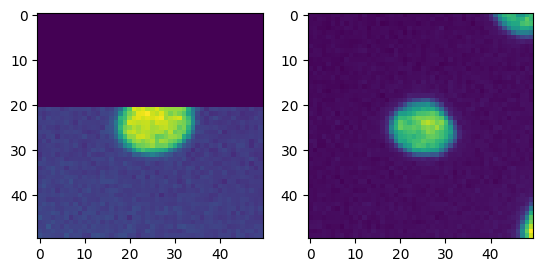

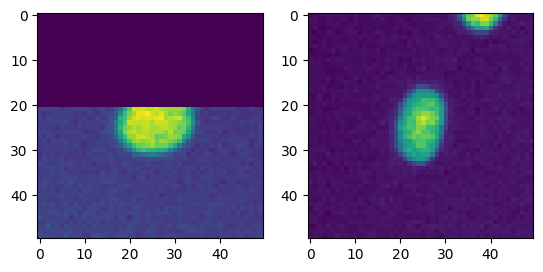

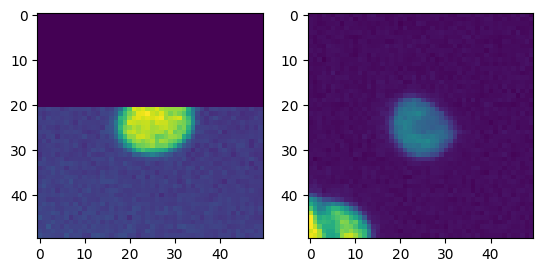

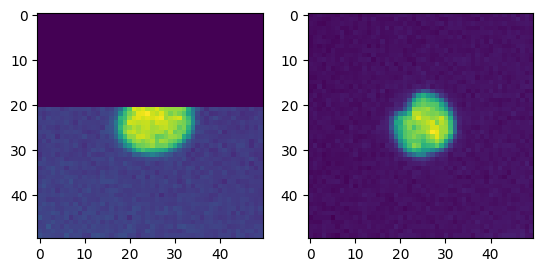

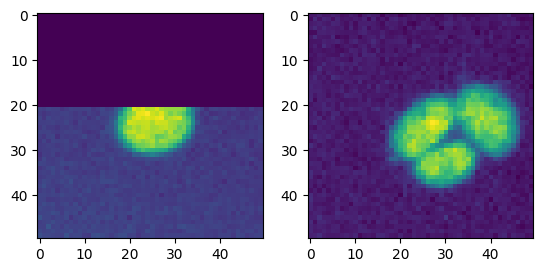

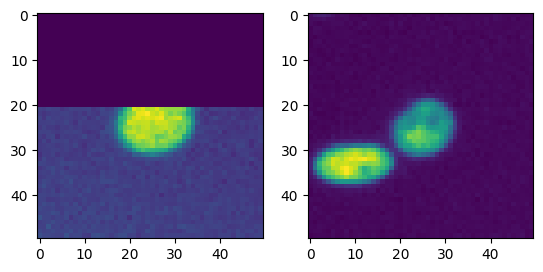

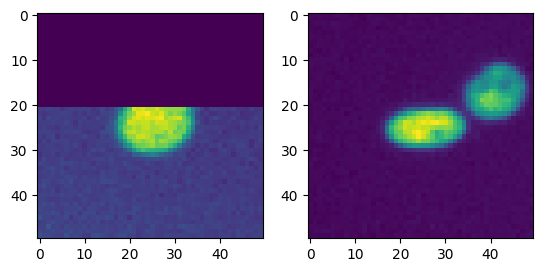

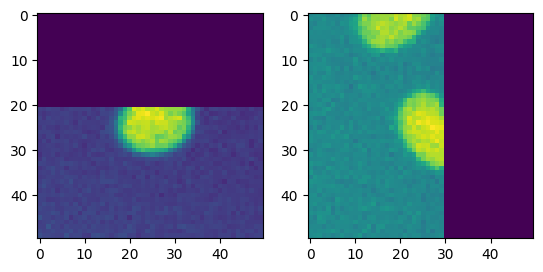

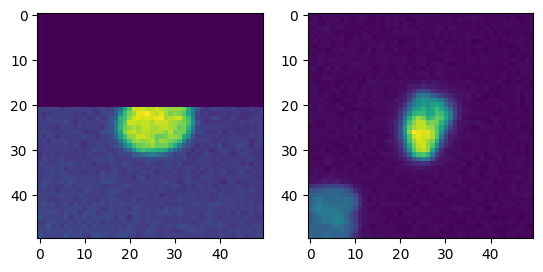

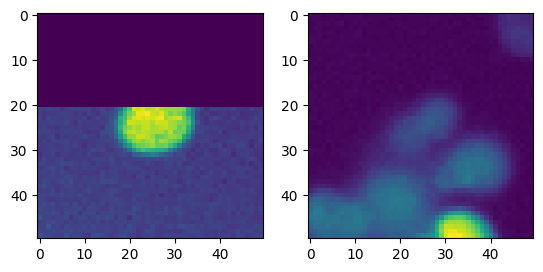

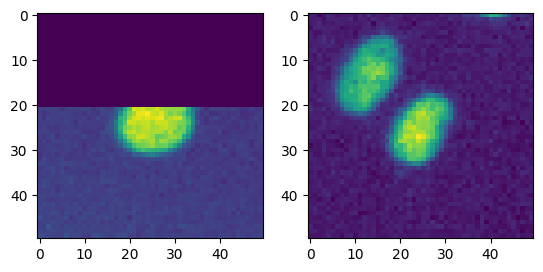

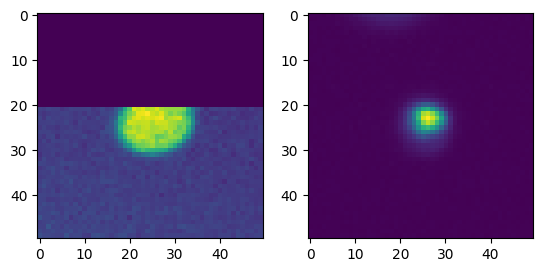

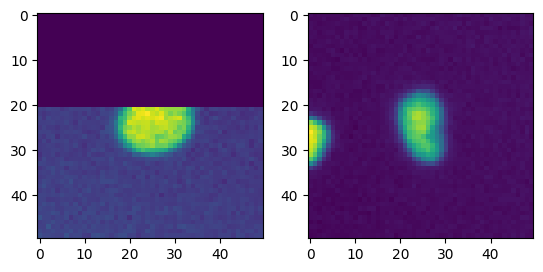

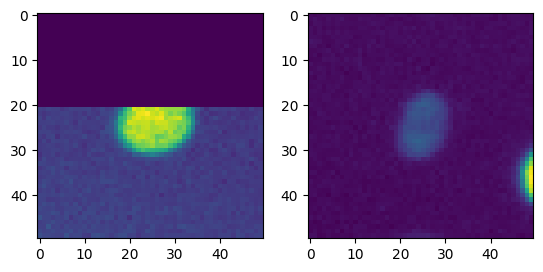

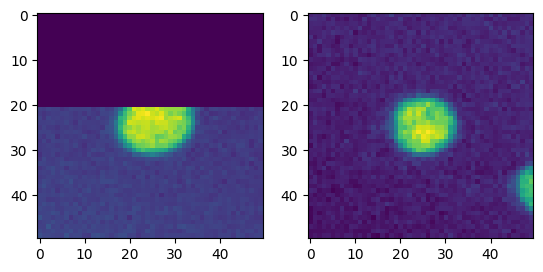

In [56]:
first_image_ci = 0

images_padded = np.array([np.pad(image, (100,100), 'constant') for image in images])
print(images_padded.shape)
for i in range(len(cos_sims_per_cell_masks_encFeats_mean[first_image_ci])):
    ele = cos_sims_per_cell_masks_encFeats_mean[first_image_ci][i]
    if ele == 1.0:
        cell_index = first_image_ci
        cell_center = (round(cell_centers[0][cell_index][0]),round(cell_centers[0][cell_index][1]))
        crop = images_padded[0][cell_center[0]-25+100:cell_center[0]+25+100, cell_center[1]-25+100:cell_center[1]+25+100]
        plt.subplot(1,2,1)
        plt.imshow(crop)

        cell_index = i
        cell_center = (round(cell_centers[1][cell_index][0]),round(cell_centers[1][cell_index][1]))
        crop = images_padded[1][cell_center[0]-25+100:cell_center[0]+25+100, cell_center[1]-25+100:cell_center[1]+25+100]

        plt.subplot(1,2,2)
        plt.imshow(crop)

        plt.show()